# Read data

In [2]:
import sys
from pathlib import Path
root_proj = Path("/Users/yk/Documents/Projects/Pre-PhD")

if str(root_proj/"src") not in sys.path:
    sys.path.append(str(root_proj/"src"))

In [3]:
import pandas as pd
from data_proc import convert_for_EV

year = 2023

chargelogs = pd.read_excel(root_proj / "DATA_SYSTEM_LIDL" / "Raw_chargelogs" / f"Chargelogs {year}.xlsx")
# convert the data frame
converted_df = convert_for_EV(chargelogs, bin=15)
converted_df.sample(20)

,Time,LFR3591EVCP01,LFR3591EVCP02,LFR3591EVCP03,LFR3591EVCP04,LFR3591EVCP05,Total
15948,2023-06-16 03:00:00,3.467495,0.000000,0.00000,3.388653,2.494508,9.350656
7015,2023-03-15 01:45:00,2.972029,0.000000,0.00000,2.182704,4.993087,10.147820
27126,2023-10-10 13:30:00,0.000000,0.000000,0.00000,4.653398,0.000000,4.653398
7538,2023-03-20 12:30:00,0.000000,0.000000,0.00000,1.765262,0.000000,1.765262
18544,2023-07-13 04:00:00,0.000000,1.063833,0.00000,5.345955,0.000000,6.409788
17496,2023-07-02 06:00:00,0.000000,0.000000,6.30186,0.000000,0.000000,6.301860
4770,2023-02-19 16:30:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
32887,2023-12-09 13:45:00,1.034603,10.422117,0.00000,0.000000,3.211075,14.667795
31493,2023-11-25 01:15:00,1.264095,0.000000,0.00000,1.560328,6.244842,9.069265
25252,2023-09-21 01:00:00,5.678192,0.000000,0.00000,5.430991,0.785914,11.895096


## Splite train and test

In [8]:
step = (60/15)*24*30*3 # three months
step = int(step)
df_train = converted_df.iloc[:-step]
df_test = converted_df.iloc[-step:]

## Plot

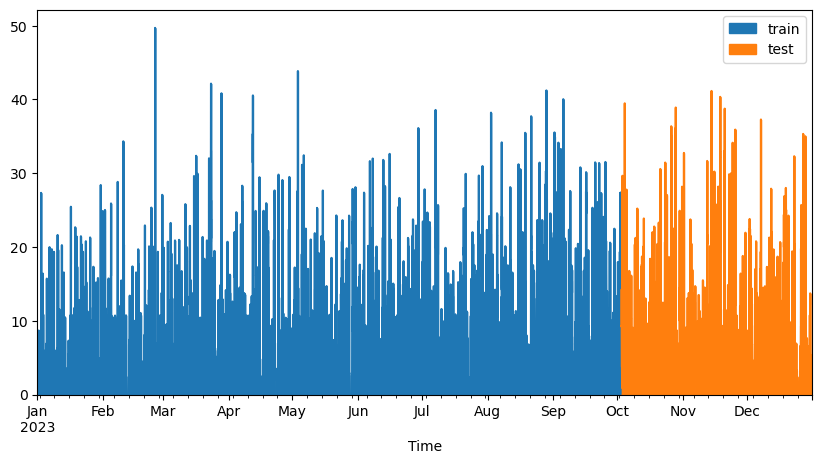

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
df_train.plot(ax=ax, label='train', x='Time', y='Total', kind='area')
df_test.plot(ax=ax, label='test', x='Time', y='Total', kind='area')
ax.legend()

plt.show()


# Training

In [ ]:
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterRecursive(
    regressor = RandomForestRegressor(random_state=42, verbose=-1),
    lags = int((60/15)*24*7), # use previous one week
    window_features = RollingFeatures(stats=['mean'], window_sizes=int((60/15)*24))
)

In [20]:
import joblib as jb
import json

output_dir = root_proj / "checkpoints" / "point02"

if not (output_dir / "log.json").is_file(): # first train
    output_dir.mkdir(parents=True, exist_ok=True)
    # training
    forecaster.fit(y=df_train['Total'], store_in_sample_residuals=True)
    # residuals = forecaster.in_sample_residuals  # 查看训练残差
    # save model
    jb.dump(forecaster, output_dir/"model.joblib")
    # log
    log = {
        "metadata": {
            "description": "recursive random forest regresion",
            "lags": int((60/15)*24*7),
            "window_features": {
                "type": "rolling",
                "stats": ["mean"],
                "window_size": int((60/15)*24)
            },
            "freq": "15min"
        },
        # "residuals": forecaster.in_sample_residuals
    }
    # save log
    with open(output_dir/"log.json", "w") as f:
        json.dump(log, f, indent=2)
    print("End of training")
else:
    # 加载模型 | load model
    forecaster = jb.load(output_dir/"model.joblib")
    # load log
    with open(output_dir/"log.json", "r") as f:
        log = json.load(f)
    print("Loaded")

Loaded


In [49]:
yhat_test = forecaster.predict(steps=len(df_test))

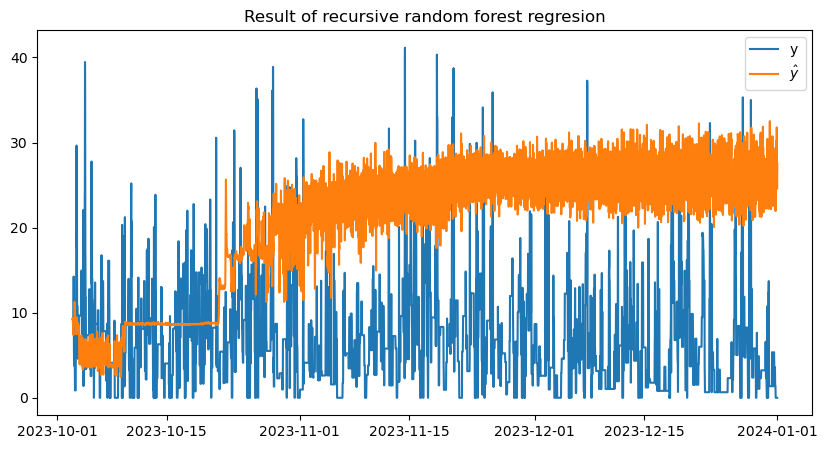

In [50]:
# Save and display the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Result of recursive random forest regresion")
ax.plot(df_test['Time'], df_test['Total'], label='y')
ax.plot(df_test['Time'], yhat_test, label=r'$\hat{y}$')
ax.legend()
# fig.autofmt_xdate() # for rotation
fig.savefig(output_dir / "prediction_test.png", dpi=300, bbox_inches='tight')
plt.show()